In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import time
import multiprocessing as mp
from tqdm.notebook import tqdm
import urllib.request
from numba import njit
import seaborn as sns
from scipy.stats import sem, t
import os
import itertools
from joblib import Parallel, delayed


## Parâmetros de configuração

In [2]:
random_runs = 50
total_cores = 10
# to achieve ~30 ants at a 500 vertex graph
ants_per_vertex = [0.02, 0.05, 0.06, 0.07 ]
max_cycles = [10, 50, 100, 500, 1000]
tau_min = [0.01, 0.1, 0.5]
tau_max = [2, 3, 6, 8]
alpha = [0, 0.75, 0.98, 1, 1.1, 2]
evaporation_rate = [0.8, 0.9, 0.95, 0.98, 0.99]

parameters = [ants_per_vertex, max_cycles, tau_min, tau_max, alpha, evaporation_rate]

# todo: colocar um arquivo super dificil, acho que o keller6

files = [("easy", "http://cedric.cnam.fr/~porumbed/graphs/dsjc500.5.col"), ("hard", "https://iridia.ulb.ac.be/~fmascia/files/DIMACS/p_hat700-2.clq")]


print(f"Total combinations for each experimentation graph: {len(list(itertools.product(*parameters)))}")

Total combinations for each experimentation graph: 7200


In [3]:
def parse_dimacs_to_adjacency_matrix(url):
    # split the last part of the url to get the filename
    filename = url.split('/')[-1]
    
    content = None
    # if the file does not exist, download it
    if not os.path.exists(filename):
        # Open the URL and read the lines
        with urllib.request.urlopen(url) as u:
            content = u.read().decode()
        # Save the content to a file
        with open(filename, 'w') as f:
            f.write(content)
    else:
        with open(filename, 'r') as f:
            content = f.read()

    # Split the content into lines
    lines = content.split("\n")
    
    # Filter only the lines that start with 'p' and 'e'
    p_lines = [line for line in lines if line.startswith('p')]
    e_lines = [line for line in lines if line.startswith('e')]

    # Parse the 'p' line to get the number of vertices
    _, _, num_vertices, _ = p_lines[0].split()
    num_vertices = int(num_vertices)

    # Initialize an empty adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices))

    # Parse each 'e' line and fill in the adjacency matrix
    for line in e_lines:
        _, vertex1, vertex2 = line.split()
        vertex1, vertex2 = int(vertex1) - 1, int(vertex2) - 1  # vertices are 1-indexed in the DIMACS format
        adjacency_matrix[vertex1][vertex2] = True
        adjacency_matrix[vertex2][vertex1] = True  # this is because the graph is undirected

    return adjacency_matrix


G = parse_dimacs_to_adjacency_matrix(files[0][1])

print(G .shape)


(500, 500)


### Plot do grafo

In [4]:

def draw_graph(G, clique=None, title=None):
    # Let's use a circular layout for the vertices
    t = np.linspace(0, 2*np.pi, num=G.shape[0]+1)[:-1]
    x = np.cos(t)
    y = np.sin(t)

    fig, ax = plt.subplots()

    # make the figsize proportional to the number of vertices
    fig.set_size_inches(6*(G.shape[0]/50), 6*(G.shape[0]/50))
    
    # draw vertices
    ax.scatter(x, y)

    # draw edges
    for i in range(G.shape[0]):
        for j in range(i+1, G.shape[0]):
            if G[i, j] == 1:
                ax.plot([x[i], x[j]], [y[i], y[j]], color='gray')

    # highlight clique
    if clique is not None:
        if not isinstance(clique, list):
            clique = list(clique)
        cx = x[clique]
        cy = y[clique]
        ax.scatter(cx, cy, color='red')
        for i in range(len(clique)):
            for j in range(i+1, len(clique)):
                ax.plot([cx[i], cx[j]], [cy[i], cy[j]], color='red')
    
    if title is not None:
        ax.set_title(title)

    plt.show()
    


### 1ª implementação, com python puro

In [5]:
def construct_clique_regular(G, tau, n, alpha):
    vi = np.random.randint(n)  # choose a first vertex
    Ck = {vi}  # initialize clique
    Candidates = {vj for vj in range(n) if G[vi, vj]}  # find neighbors

    while Candidates:  # continue while there are candidates
        probs = [tau[vi, vj] for vj in Candidates]  # get pheromone trails
        probs   = np.power(probs, alpha)  # raise to alpha factor
        probs /= np.sum(probs)  # normalize to get probabilities
        vi = np.random.choice(list(Candidates), p=probs)  # choose next vertex

        new_neighbors = {vj for vj in range(n) if G[vi, vj]}  # find new neighbors
        Candidates &= new_neighbors  # update candidates to be the intersection of current candidates and new neighbors

        if all(G[vi][v] for v in Ck):  # if the new vertex is a neighbor of all vertices in the current clique
            Ck.add(vi)  # then add it to the clique

    return Ck

In [6]:
@njit
def seed_numba(seed: int):
    np.random.seed(seed)

# as we are using numba, we need to define a function to set the seed _using_ numba compiled function, 
# as it is different from the numpy one
def seed(seed: int):
    np.random.seed(seed)
    seed_numba(seed)

@njit
def choice_with_weights(probs):
    cumulative_probs = np.cumsum(probs)
    random_sample = np.random.rand()
    for i in range(len(probs)):
        if random_sample < cumulative_probs[i]:
            return i
    return len(probs) - 1

### Função otimizada com numba

In [7]:
@njit
def construct_clique(G, tau, n, alpha):
    vi = np.random.randint(n)  # choose a first vertex
    Ck = np.zeros(n, dtype=np.bool_)  # initialize clique. If True, the vertex is in the clique
    Ck[vi] = True

    Candidates = np.zeros(n, dtype=np.bool_) 

    # link all neighbors of vi
    for vj in range(n):
        if G[vi, vj]:
            Candidates[vj] = True

    while np.any(Candidates): 
        # get pheromone trails of vertices
        probs = np.zeros(n) 
        
        # only has probability if its a candidate, ie, neighbor of current clique
        for vj in range(n):
            if Candidates[vj]:
                probs[vj] = np.power(tau[vi][vj], alpha)

        # normalize to get probabilities
        total = np.sum(probs)
        probs = probs / total if total > 0 else probs

        # choose next vertex. equivalent to np.random.choice(list(Candidates), p=probs)
        vi = choice_with_weights(probs)

        # find vi neightbors
        vi_neighbors = np.zeros(n, dtype=np.bool_)
        for vj in range(n):
            if G[vi][vj]:
                vi_neighbors[vj] = True

        # update candidates to be the intersection of current candidates and new neighbors
        #
        # The new candidates are the neighbors of the new vertex that are also 
        # neighbors of all vertices in the current clique
        Candidates = np.logical_and(Candidates, vi_neighbors)
       

        # Only add to clique if the new vertex is a neighbor of all vertices in the current clique
        if np.all(G[vi][Ck]):
            Ck[vi] = True  # then add it to the clique

    # get the indices of the vertices in the clique
    Ck = np.where(Ck)[0]

    return Ck

In [8]:
def hash_clique(clique):
    ordered_clique = sorted(clique)
    return hash(tuple(ordered_clique))


def ant_clique(G, ants_per_v, maxCycles, tauMin, tauMax, alpha=1.05, evaporation_rate=0.9, plot=False):
    tau = np.full_like(G, tauMax)  # initialize pheromone trails
    n = len(G)  # number of vertices in the graph
    
    
    best_clique_lengths = np.zeros(maxCycles)
    tau_means = np.zeros(maxCycles)
    bestClique = set()

    total_ants = int(np.ceil(ants_per_v * n))

    # handling repeated cliques
    repeated_cliques = {}
    iteration_with_best = 0

    for cycle in range(maxCycles):
        #cliques = pool.starmap(construct_clique, [(G, tau, n, alpha) for _ in range(ants_per_v)])

        cliques = [construct_clique(G, tau, n, alpha) for _ in range(total_ants)]  # construct cliques
        iteration_best_clique = max(cliques, key=len)
        
        title = f"Cicle {cycle+1}/{maxCycles} - Largest clique: {len(iteration_best_clique)} vertices"
        if plot:
            draw_graph(G, iteration_best_clique, title)

        # check if the clique is repeated
        clique_sorted = tuple(sorted(iteration_best_clique))

        # count how many times this clique was repeated
        repeated_cliques[clique_sorted] = repeated_cliques.get(clique_sorted, 0) + 1

        if len(iteration_best_clique) > len(bestClique):
            iteration_with_best = cycle
            bestClique = iteration_best_clique

        # pheromone addition
        # o 1/(1+ | Cbest | − | Ck |)
        pheromone_addition = 1 / (1 + len(bestClique) - len(iteration_best_clique))
        #print(f"pheromone_addition: {pheromone_addition}")

        tau = np.multiply(tau, evaporation_rate )
        

        # update pheromone trails
        for vi in iteration_best_clique:
            for vj in iteration_best_clique:
                if vi != vj:
                    tau[vi, vj] += pheromone_addition

        # enforce minimum and maximum pheromone trail limits
        tau = np.clip(tau, tauMin, tauMax)
        best_clique_lengths[cycle] = len(bestClique)
        tau_means[cycle] = np.mean(tau)

    return bestClique, best_clique_lengths, tau_means, repeated_cliques, iteration_with_best

bestClique, _, _, _, _ = ant_clique(G, 0.03, 500, 0.01, 6, 1)

print(f"Maximal clique: {bestClique} with {len(bestClique)} vertices")



Maximal clique: [ 97 111 145 206 300 341 353 373 442 444 466 486] with 12 vertices


#### Função de experimentação

In [9]:

def experiment(G, progress_bar, ants_per_v=100, maxCycles=1000, tauMin=1, tauMax=6, alpha=1.05, evaporation_rate=0.9):
    global_best = set()
    final_results = np.zeros(random_runs)
    tau_means_ci = []
    best_clique_lengths_ci = []
    repeated_cliques_ci = []
    iteration_with_best_ci = np.zeros(random_runs)

    iterator = range(random_runs)

    if progress_bar:
        iterator =  tqdm(range(random_runs), desc='Confidence interval loop')

    for i in iterator:
        seed(i)
        bestClique, best_clique_lengths, tau_means, repeated_cliques, iteration_with_best = ant_clique(G, ants_per_v, maxCycles, tauMin, tauMax, alpha, evaporation_rate)
        tau_means_ci.append(tau_means)
        best_clique_lengths_ci.append(best_clique_lengths)
        repeated_cliques_ci.append(repeated_cliques)
        final_results[i] = len(bestClique)
        iteration_with_best_ci[i] = iteration_with_best

        if len(bestClique) > len(global_best):
            global_best = bestClique

    #print(f"Best clique: {global_best} with {len(global_best)} vertices")
    return final_results, global_best, tau_means_ci, best_clique_lengths_ci, repeated_cliques_ci, iteration_with_best_ci

final_results, global_best, tau_means_runs, best_clique_lengths_runs, repeated_cliques_runs, iteration_with_best_runs = experiment(G, True, 0.1, 50, 0.1, 6, 6)


Confidence interval loop:   0%|          | 0/50 [00:00<?, ?it/s]

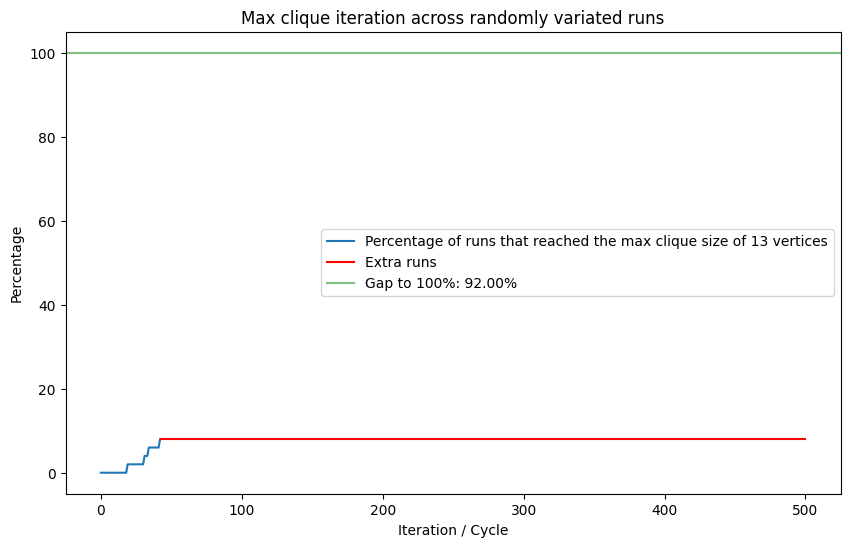

0.92
43


In [10]:

def plot_iterations_to_max(iterations_to_max, max_values, total_iterations=1000):
    # convert to numpy arrays with integer values
    iterations_to_max = np.array(iterations_to_max, dtype=int)
    max_values = np.array(max_values, dtype=int)

    # Get the global max value and max iterations

    global_max = int(np.max(max_values))
    max_iterations = int(np.max(iterations_to_max))

    # Initialize an array to hold the count of max values reached at each iteration
    reached_max = np.zeros(max_iterations+1)

    for index, i in enumerate(iterations_to_max):
        # If the run reached the max, increment the count for that iteration and all subsequent iterations
        if i <= max_iterations and np.max(max_values[index]) == global_max:
            reached_max[i:] += 1

    # Calculate the percentage of runs that reached the max at each iteration
    pct_reached_max = (reached_max / len(iterations_to_max)) * 100


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(max_iterations+1), pct_reached_max, label=f"Percentage of runs that reached the max clique size of {global_max} vertices")

    # extra runs
    x = np.arange(max_iterations+1, total_iterations+1)
    y = np.full(x.shape, np.max(pct_reached_max))

    plt.plot(x, y, color='red', label="Extra runs")

    # line at 100%
    plt.axhline(y=100, color='g', linestyle='-', alpha=0.5, label="Gap to 100%: {:.2f}".format(100 - np.max(pct_reached_max)) + "%")

    # add vertical lines every time a 10% increase is reached
    for i in range(10, 110, 10):  # from 10% to 100%, with step size 10%
        iteration = np.searchsorted(pct_reached_max, i)
        if iteration != len(pct_reached_max):  # check if the percentage was reached
            plt.axvline(x=iteration, color='k', linestyle=':', alpha=0.5, label=f"{i}% of runs at {iteration} iterations")
    

    plt.xlabel("Iteration / Cycle")
    plt.ylabel("Percentage")
    plt.title("Max clique iteration across randomly variated runs")
   
    plt.legend()
    plt.show()

def runs_away_from_maximum(iterations_to_max, max_values):
    # convert to numpy arrays with integer values
    iterations_to_max = np.array(iterations_to_max, dtype=int)
    max_values = np.array(max_values, dtype=int)

    # Get the global max value and max iterations
    global_max = int(np.max(max_values))
    max_iterations = int(np.max(iterations_to_max))

    # Initialize an array to hold the count of max values reached at each iteration
    reached_max = np.zeros(max_iterations+1)

    for index, i in enumerate(iterations_to_max):
        # If the run reached the max, increment the count for that iteration and all subsequent iterations
        if i <= max_iterations and np.max(max_values[index]) == global_max:
            reached_max[i:] += 1

    # Calculate the percentage of runs that reached the max at each iteration
    pct_reached_max = (reached_max / len(iterations_to_max))

    return round(1 - np.max(pct_reached_max), 3)

def iterations_to_reach_desired_percentage(iterations_to_max, max_values, desired_percentage=.8):
    # convert to numpy arrays with integer values
    iterations_to_max = np.array(iterations_to_max, dtype=int)
    max_values = np.array(max_values, dtype=int)

    # Get the global max value and max iterations
    global_max = int(np.max(max_values))
    max_iterations = int(np.max(iterations_to_max))

    # Initialize an array to hold the count of max values reached at each iteration
    reached_max = np.zeros(max_iterations+1)

    for index, i in enumerate(iterations_to_max):
        # If the run reached the max, increment the count for that iteration and all subsequent iterations
        if i <= max_iterations and np.max(max_values[index]) == global_max:
            reached_max[i:] += 1

    # Calculate the percentage of runs that reached the max at each iteration
    pct_reached_max = (reached_max / len(iterations_to_max))

    return np.searchsorted(pct_reached_max, desired_percentage)


plot_iterations_to_max(iteration_with_best_runs, best_clique_lengths_runs, 500)

print(runs_away_from_maximum(iteration_with_best_runs, best_clique_lengths_runs))
print(iterations_to_reach_desired_percentage(iteration_with_best_runs, best_clique_lengths_runs))

### Estratégia de memorização de valores da experimentação em disco

In [11]:
cache_file = 'cache.csv'

save_count = 0
load_count = 0

def load_or_create_cache():
    # Check if the cache file exists
    if os.path.isfile(cache_file):
        # Load the cache file
        cache_df = pd.read_csv(cache_file)
    else:
        # Create an empty DataFrame with the required columns
        cache_df = pd.DataFrame(columns=["file", "best_clique", "ants_per_v", "final_std", "alpha", "tmin", "tmax", "maxCycles", "evaporation_rate", "p_runs_away_from_maximum", "iterations_to_reach_80pct"])

    # Convert stringified JSON columns back to lists/arrays
    #for column in ["clique_mean", "best_clique_random_runs", "tau_means_runs", "stds"]:
    #    cache_df[column] = cache_df[column].apply(deserialize_data)

    return cache_df

def convert_to_primitives(data):
    if isinstance(data, np.ndarray):
        return data.tolist()
    if isinstance(data, dict):
        temp = {}
        for k, v in data.items():
            # Convert tuple keys to strings
            if isinstance(k, tuple):
                k = str(k)
            converted_k = convert_to_primitives(k)
            converted_v = convert_to_primitives(v)
            temp[converted_k] = converted_v
        return temp
    if isinstance(data, list):
        temp = []
        for item in data:
            converted_item = convert_to_primitives(item)
            temp.append(converted_item)
        return temp
    return data
    
def serialize_data(data):
    # check if np array
    temp = convert_to_primitives(data)
    
    return json.dumps(temp)

def deserialize_data(data):
    if isinstance(data, str):
        if data.startswith("(") and data.endswith(")"):
            return tuple(map(int, data[1:-1].split(',')))
    if isinstance(data, list):
        return [deserialize_data(item) for item in data]
    if isinstance(data, dict):
        return {deserialize_data(k): deserialize_data(v) for k, v in data.items()}
    return data

def load_cache(cache_df, file, run_parameters):
    global load_count

    alpha_value = run_parameters['alpha']
    tmin = run_parameters['tauMin']
    tmax = run_parameters['tauMax']
    maxCycles = run_parameters['maxCycles']
    ants_per_v = run_parameters['ants_per_v']
    maxCycles = run_parameters['maxCycles']
    evaporation_rate = run_parameters['evaporation_rate']

    cache_df["alpha"] = pd.to_numeric(cache_df["alpha"], errors='coerce')
    cache_df["alpha"] = np.round(cache_df["alpha"], 3)

    # Filter DataFrame based on conditions
    cache_result = cache_df.query(
        f'file == "{file}" and '
        f'ants_per_v == {ants_per_v} and '
        f'maxCycles == {maxCycles} and '
        f'alpha == {round(alpha_value, 3)} and '
        f'tmax == {tmax} and '
        f'maxCycles == {maxCycles} and '
        f'evaporation_rate == {evaporation_rate} and '
        f'tmin == {tmin}'
    )
    # final_results, global_best, tau_means_runs, best_clique_lengths_runs 
    # Check if there's a match
    if not cache_result.empty:
        load_count += 1
        if load_count % 100 == 0:
            print(f"Loaded {load_count} times")
        
        #display(cache_result)
   
        return True
    else:
        return False


def save_cache(cache_df, data, best_clique, file, run_parameters):

    global save_count
    alpha_value = run_parameters['alpha']
    evaporation_rate = run_parameters['evaporation_rate']
    tmin = run_parameters['tauMin']
    tmax = run_parameters['tauMax']
    maxCycles = run_parameters['maxCycles']
    ants_per_v = run_parameters['ants_per_v']
    
    (final_std, p_runs_away_from_maximum, iterations_to_reach_80pct)  = data

    new_row = {
        "file": file,
        "best_clique": best_clique,
        "ants_per_v": ants_per_v,
        "final_std" : final_std,
        "alpha": alpha_value,
        "tmin": tmin,
        "tmax": tmax,
        "maxCycles": maxCycles,
        "evaporation_rate": evaporation_rate,
        "p_runs_away_from_maximum": p_runs_away_from_maximum,
        "iterations_to_reach_80pct": iterations_to_reach_80pct
    }
   
    cache_df = pd.concat([cache_df, pd.DataFrame([new_row])], ignore_index=True)
    cache_df.to_csv(cache_file, index=False)
    save_count += 1
    if save_count % 100 == 0:
        print(f"Saved {save_count} times")
    
    return cache_df

run_parameters = {
    'ants_per_v': 100,
    'maxCycles': 200,
    'tauMin': 0.1,
    'tauMax': 6,
    'alpha': 2,
    'evaporation_rate': 0.9  # default value from the function definition
}


#### Testando se funciona

In [12]:

# testing the save
cache_df = load_or_create_cache()
# just placeholders
data = (0, 0, 0)

cache_df = save_cache(cache_df, data, 13, 'test', run_parameters)

# testing retrieval
cache_test = load_cache(cache_df, 'test', run_parameters)

cache_df.info()

load_count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5316 entries, 0 to 5315
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   file                       5316 non-null   object 
 1   best_clique                5316 non-null   float64
 2   ants_per_v                 5316 non-null   float64
 3   final_std                  5316 non-null   float64
 4   alpha                      5316 non-null   float64
 5   tmin                       5316 non-null   float64
 6   tmax                       5316 non-null   float64
 7   maxCycles                  5316 non-null   int64  
 8   evaporation_rate           5316 non-null   float64
 9   p_runs_away_from_maximum   5316 non-null   float64
 10  iterations_to_reach_80pct  5316 non-null   int64  
dtypes: float64(8), int64(2), object(1)
memory usage: 457.0+ KB


1

### Execução paralela do experimento

In [13]:
cache_df = load_or_create_cache()

def worker(combination, G, current_file):
    ants_per_v, maxCycles, tauMin, tauMax, alpha, evaporation_rate = combination
    run_parameters = {
        'ants_per_v': ants_per_v,
        'maxCycles': int(maxCycles),
        'tauMin': tauMin,
        'tauMax': tauMax,
        'alpha': alpha,
        'evaporation_rate': evaporation_rate
    }
    if load_cache(cache_df, current_file, run_parameters) is False:
        data = experiment(G, False, **run_parameters)
        best_clique = data[1]
        
        best_clique_lengths_runs = data[3]
        iterations_to_max = data[-1]

        p_runs_away_from_maximum = runs_away_from_maximum(iterations_to_max, best_clique_lengths_runs)
        iterations_to_reach_80pct = iterations_to_reach_desired_percentage(iterations_to_max, best_clique_lengths_runs, 0.8)

        final_std = np.std(best_clique_lengths_runs, axis=0)[-1]
    
        data_cache = (final_std, p_runs_away_from_maximum, iterations_to_reach_80pct)
        return (data_cache, len(best_clique), current_file, run_parameters, best_clique)
    else:
        return None


def run_experiment(G, run_combinations, file_label):
    # Use joblib's Parallel and delayed to parallelize the experiment
    results = Parallel(n_jobs=total_cores)(delayed(worker)(combination.tolist(), G, file_label) for combination in run_combinations)
    return results


print(f"Using {total_cores} cores! Check your CPU usage and how many cores available to avoid memory errors.")

for file_label, path in files:
    G = parse_dimacs_to_adjacency_matrix(path)
    combinations = list(itertools.product(*parameters))
    print(f"Total number of combinations: {len(combinations)}")

    # Split the combinations into batches of 5
    batches = np.array_split(combinations, np.ceil(len(combinations)/total_cores))

    for batch in tqdm(batches, desc=f"File: \"{file_label}\" with {len(G)} vertices"):
        results = run_experiment(G, batch, file_label)
        # filter results that are already in the cache
        results = [x for x in results if x is not None]
        for data, len_best_clique, _, run_parameters, best_clique in results:
            cache_df = save_cache(cache_df, data, len_best_clique, file_label, run_parameters)



Using 10 cores! Check your CPU usage and how many cores available to avoid memory errors.
Total number of combinations: 7200


File: "easy" with 500 vertices:   0%|          | 0/720 [00:00<?, ?it/s]

Saved 100 times


### Execução sequencial

Deixei aqui para fins de debugging, é mais fácil ver o que acontece dentro dela.
Se você tiver rodado a célula de cima até o final, a execução deve pegar todos os dados do cache.

In [ ]:

cache_df = load_or_create_cache()


def worker(combination, G, file_label):
    ants_per_v, maxCycles, tauMin, tauMax, alpha, evaporation_rate = combination
    run_parameters = {
        'ants_per_v': ants_per_v,
        'maxCycles': int(maxCycles),
        'tauMin': tauMin,
        'tauMax': tauMax,
        'alpha': alpha,
        'evaporation_rate': evaporation_rate
    }
    if load_cache(cache_df, file_label, run_parameters) is False:
        data = experiment(G, False, **run_parameters)
        best_clique = data[1]
        
        best_clique_lengths_runs = data[3]
        iterations_to_max = data[-1]

        p_runs_away_from_maximum = runs_away_from_maximum(iterations_to_max, best_clique_lengths_runs)
        iterations_to_reach_80pct = iterations_to_reach_desired_percentage(iterations_to_max, best_clique_lengths_runs, 0.8)

        final_std = np.std(best_clique_lengths_runs, axis=0)[-1]
    
        data_cache = (final_std, p_runs_away_from_maximum, iterations_to_reach_80pct)
        return (data_cache, len(best_clique), file_label, run_parameters, best_clique)
    else:
        return None


def run_experiment(G, combination, file_label):
    # removed the parallelization here
    results = worker(combination, G, file_label)
    return results


for file_label, path in files:
    G = parse_dimacs_to_adjacency_matrix(path)
    combinations = list(itertools.product(*parameters))
    print(f"Total number of combinations: {len(combinations)}")


    for batch in tqdm(combinations, desc=f"File: \"{file_label}\" with {len(G)} vertices"):
        result = run_experiment(G, batch, file_label )
        # filter results that are already in the cache
        if result is not None:
            data, len_best_clique, _, run_parameters, best_clique = result
            cache_df = save_cache(cache_df, data, len_best_clique, file_label, run_parameters)



### Plot de experimentação de um dado experimento

In [ ]:
def plot_results(final_results, tau_means_runs, best_clique_lengths_runs, repeated_cliques_runs):
    plt.figure(figsize=(12, 18))
    plt.subplot(3, 2, 1)
    plt.plot(final_results, label='Final results')
    plt.title("Maximal clique size over maxCycles")
    plt.xlabel("maxCycles")
    plt.ylabel("Clique size")
    plt.legend()
    

    best_run_index = 0
    best_clique_length = 0

    for i, best_clique_length_run in enumerate(best_clique_lengths_runs):
        if max(best_clique_length_run) > best_clique_length:
            best_run_index = i
            best_clique_length = max(best_clique_length_run)

    #print("Best clique is: ", best_clique_length, "at i = ", best_run_index)
    
    plt.subplot(3, 2, 2)
    plt.plot(best_clique_lengths_runs[best_run_index], label='Best Clique')
    plt.title("Maximal clique size over time")
    plt.xlabel("time")
    plt.ylabel("Clique size")
    plt.legend()
   

    # Compute the mean and standard error of the mean for tau_means_runs
    tau_means_mean = np.mean(tau_means_runs, axis=0)
    tau_means_sem = sem(tau_means_runs, axis=0)

    # Compute the confidence intervals
    confidence_interval_tau_means = t.interval(0.95, len(tau_means_mean)-1, loc=tau_means_mean, scale=tau_means_sem)

    # Compute the mean and standard error of the mean for best_clique_lengths_runs
    best_clique_lengths_mean = np.mean(best_clique_lengths_runs, axis=0)
    best_clique_lengths_sem = sem(best_clique_lengths_runs, axis=0)

    # Compute the confidence intervals
    confidence_interval_best_clique_lengths = t.interval(0.95, len(best_clique_lengths_mean)-1, loc=best_clique_lengths_mean, scale=best_clique_lengths_sem)


    plt.subplot(3, 2, 3)
    plt.plot(tau_means_mean, label="Mean")
    plt.fill_between(range(len(tau_means_mean)), confidence_interval_tau_means[0], confidence_interval_tau_means[1], color='b', alpha=.1, label="Confidence Interval")
    plt.title("Tau Means Over Time")
    plt.xlabel("Iterations")
    plt.ylabel("Mean Tau")
    plt.legend()

    plt.subplot(3, 2, 4)
    plt.plot(best_clique_lengths_mean, label="Mean")
    plt.fill_between(range(len(best_clique_lengths_mean)), confidence_interval_best_clique_lengths[0], confidence_interval_best_clique_lengths[1], color='b', alpha=.1, label="Confidence Interval")
    plt.title("Confidence interval of Clique Lengths Over Time")
    plt.xlabel("Iterations")
    plt.ylabel("Clique Length")
    plt.legend()

    # repetition box plot

    repetitions_by_length = {}

    # For each run
    for repeated_cliques in repeated_cliques_runs:
        # For each clique in this run
        for clique, repetitions in repeated_cliques.items():
            # Get the length of this clique
            length = len(clique)
            # If this length is not already a key in the dictionary, add it with an empty list as the value
            if length not in repetitions_by_length:
                repetitions_by_length[length] = []
            # Append the number of repetitions of this clique to the list for this length
            repetitions_by_length[length].append(repetitions)

    # Create lists for the boxplot
    lengths = []
    repetition_counts = []
    for length, repetitions in sorted(repetitions_by_length.items()):
        lengths.append(str(length))  # Boxplot's labels must be strings
        repetition_counts.append(repetitions)

    # Create the boxplot
    plt.subplot(3, 2, 5)
    plt.boxplot(repetition_counts, labels=lengths)
    plt.xlabel('Clique length')
    plt.ylabel('Repetitions')
    plt.title('Repetitions of cliques by length')
    


    plt.tight_layout()
    plt.show()

plot_results(final_results, tau_means_runs, best_clique_lengths_runs, repeated_cliques_runs)


In [ ]:
draw_graph(G, bestClique)